# Partial Least Squares Model of Differentiation Signatures using AP-1 Bulk Gene Expression

Natacha Comandante-Lou

Nov, 2021

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import LeaveOneOut
import copy
import colorcet as cc
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
%matplotlib inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Tsoi et al Model


_Data source:_

Tsoi, J., Robert, L., Paraiso, K., Galvan, C., Sheu, K. M., Lay, J., Wong, D., Atefi, M., Shirazi, R., Wang, X., Braas, D., Grasso, C. S., Palaskas, N., Ribas, A., & Graeber, T. G. (2018). Multi-stage Differentiation Defines Melanoma Subtypes with Differential Vulnerability to Drug-Induced Iron-Dependent Oxidative Stress. Cancer cell, 33(5), 890–904.e5. https://doi.org/10.1016/j.ccell.2018.03.017

### 1. Read data

In [2]:
log2fpkm = pd.read_csv('Tsoi_log2_GSE80829_FPKM.csv').rename({'Gene':'cell_line_id'},axis = 1).set_index('cell_line_id').T
log2fpkm['cell_line'] = log2fpkm.index.str.replace('_DMSO','')
log2fpkm.reset_index(drop=True,inplace=True)

metadata = pd.read_csv('Tsoi_GSE80829_metadata.csv')

#Create a single dataframe (use merge in case metadata.csv is ordered differently)
df = pd.merge(metadata,log2fpkm,on="cell_line")
df.cell_type = pd.Series(df["cell_type"], dtype="category").cat.reorder_categories(['Melanocytic','Transitory','Neural crest like','Undifferentiated'])

del log2fpkm, metadata

#### - List of AP-1 genes

In [3]:
ap1_names = ["FOS","FOSL1","FOSL2","FOSB",
             "JUN","JUNB","JUND",
             "ATF1","ATF2","ATF3","ATF4","ATF5","ATF6","ATF6B","ATF7"]

#### - Define model input and output

In [4]:
selected_factors = ap1_names
metadata_columns = ['cell_line','cell_type','M_score','MT_score','T_score','TN_score','N_score','NU_score','U_score']
df_selected = df[np.concatenate([metadata_columns,selected_factors])]

seed_id = 1 

#PLSR input(X) and output(Y)---
X = df_selected.drop(metadata_columns,axis = 1,inplace=False) #AP-1 gene expression
Y = df_selected[metadata_columns[2:]] #Tsoi differentiation signature scores

Xz = StandardScaler().fit_transform(X)
Yz = StandardScaler().fit_transform(Y)


### 2. Model Performance

In [5]:
#Evalulating model fit (R2)
r2_scores = list()
for k in np.arange(len(X.columns))+1:
    pls = PLSRegression(n_components=k)
    # fit model
    pls.fit(Xz, Yz)
    # evaluate model
    Yhat = pls.predict(Xz)
    # store
    r2_score = explained_variance_score(Yz, Yhat,multioutput='uniform_average')
    r2_scores.append(r2_score)
    
#Evalulating model leave-one-out prediction (Q2)
q2_scores = list()
for k in np.arange(len(X.columns))+1:
    pls = PLSRegression(n_components=k)
    
 
    loo = LeaveOneOut()
    Y_pred = list()

    for train_ix, test_ix in loo.split(Xz):
        # split data
        X_train, X_test = Xz[train_ix, :], Xz[test_ix, :]
        Y_train, Y_test = Yz[train_ix,:], Yz[test_ix,:]
        
        # fit model
        pls.fit(X_train, Y_train)
        # evaluate model
        Yhat = pls.predict(X_test)
        # store
        Y_pred.append(Yhat[0,:])
    q2_score = explained_variance_score(Yz, Y_pred,multioutput='uniform_average')
    q2_scores.append(q2_score)




In [6]:
#save 
model_performance = pd.DataFrame({'r2':r2_scores,'q2':q2_scores})
model_performance.to_csv('Tsoi_PLSR_Model_Performance.csv')

#### - Plot R<sup>2</sup> and Q<sup>2</sup>

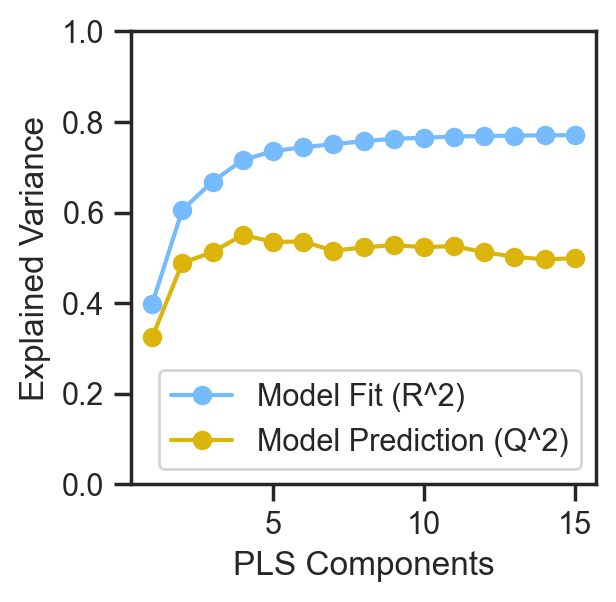

In [7]:
plt.figure(figsize=(3,3))
plt.plot(np.arange(len(X.columns))+1, r2_scores,'-o',color = 'xkcd:sky blue',label='Model Fit (R^2)') #R2
plt.plot(np.arange(len(X.columns))+1, q2_scores,'-o',color = 'xkcd:gold',label='Model Prediction (Q^2)')#Q2

plt.ylim([0,1])
plt.xlabel("PLS Components")
plt.ylabel("Explained Variance")

plt.legend(loc = 'lower right')

opt_ncomp = 4 #optimal number of PLS components chosen

plt.savefig('Tsoi_PLSR_Model_Performance.pdf', format='pdf')

#### - Data vs. Model Clustergram

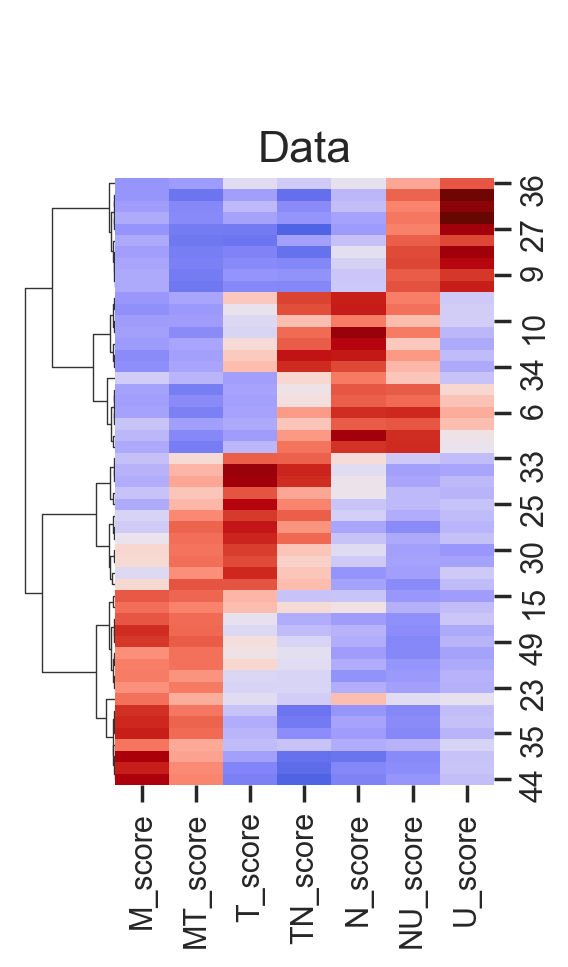

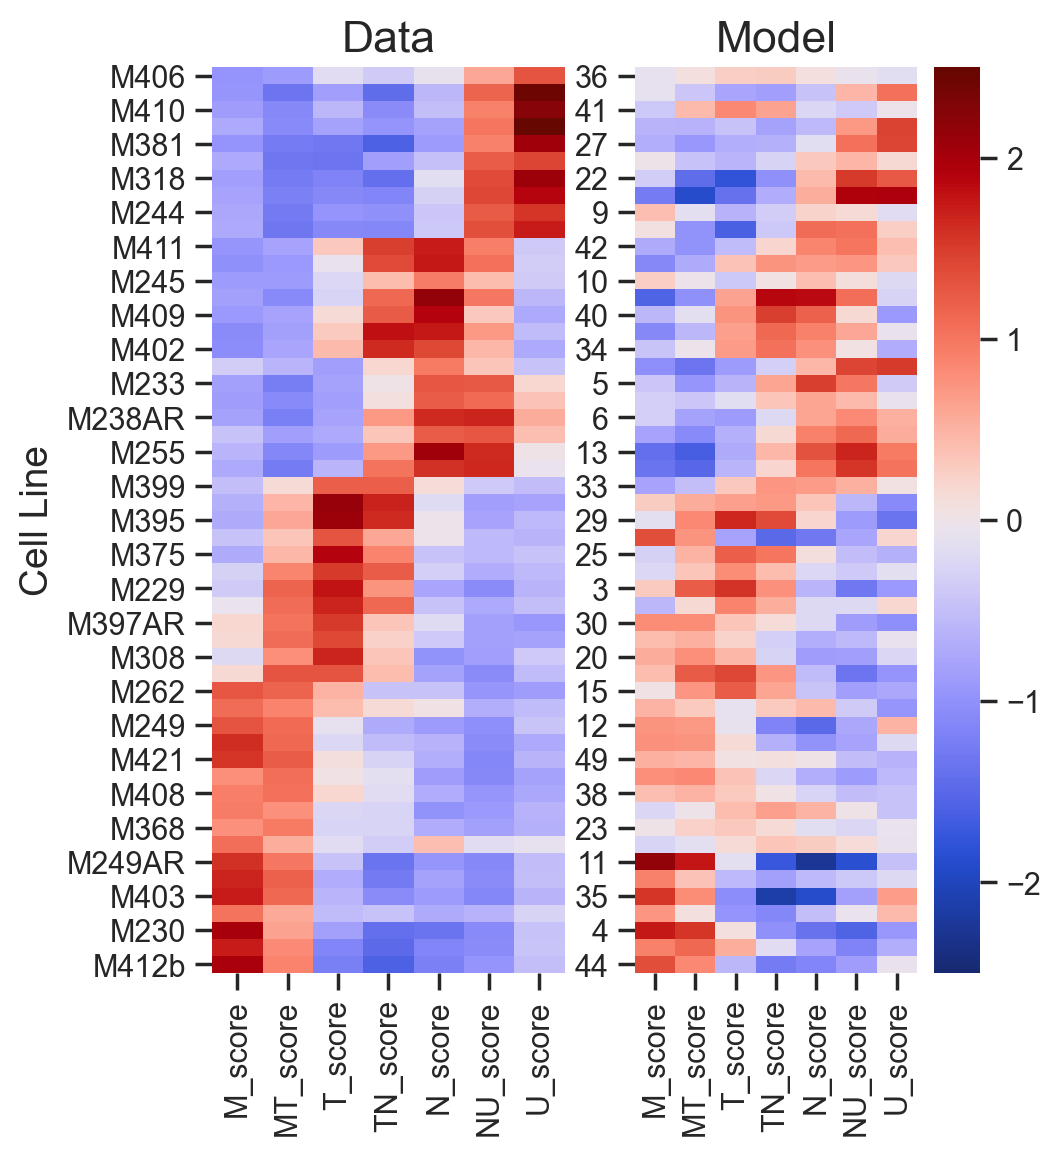

In [8]:

pls = PLSRegression(n_components=opt_ncomp) #use the optimal number of PLS components(n_comp = 4)

loo = LeaveOneOut()
Y_pred = list()

for train_ix, test_ix in loo.split(Xz):
    # split data
    X_train, X_test = Xz[train_ix, :], Xz[test_ix, :]
    Y_train, Y_test = Yz[train_ix,:], Yz[test_ix,:]

    # fit model
    pls.fit(X_train, Y_train)
    # evaluate model
    Yhat = pls.predict(X_test)
    # store
    Y_pred.append(Yhat[0,:])


df_Y_pred = pd.DataFrame(Y_pred,columns = Y.columns)
df_Yz = pd.DataFrame(Yz,columns = Y.columns)


#cluster data
cmap = cc.CET_D1A

c = sns.clustermap(df_Yz,col_cluster=False,method ='complete',metric = 'correlation',z_score=1,
                   cmap = cmap,center=0,vmax = 2.5,vmin = -2.5,figsize=(3,5),cbar_pos=None)

c.ax_heatmap.set_title('Data',fontsize = 16)

#order model prediction based on clustering of the data 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(5,6))
r_order = c.dendrogram_row.reordered_ind

df_Y_ordered = df_Yz.reindex(r_order)
df_Y_ordered.index = df_selected['cell_line'][r_order]
d = sns.heatmap(df_Y_ordered,cmap = cmap,center=0,vmax = 2.5,vmin = -2.5,ax = ax[0],cbar=False)
d.set_ylabel('Cell Line', fontsize = 14)
d.set_title('Data',fontsize = 16)

df_Y_pred_ordered = df_Y_pred.reindex(r_order)
m = sns.heatmap(df_Y_pred_ordered,cmap = cmap,center=0,vmax = 2.5,vmin = -2.5,ax = ax[1])
m.set_title('Model',fontsize = 16)

plt.savefig('Tsoi_PLSR_Clustergram_Data_vs_Model.pdf', format='pdf')

#### - Save Prediction Output

In [9]:
df_Y_pred['cell_line'] = df_selected['cell_line']
df_Y_pred['cell_type'] = df_selected['cell_type']
df_Y_pred.to_csv('Tsoi_PLSR_LOO_Prediction_Output.csv')

### 3. Variable Importance in Projection Scores

In [10]:
#Calculate VIP scores for each y-response:
def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    
    p, h = w.shape
    k,_ = q.shape
    
    vips = np.zeros((p,k))
    
    for r in range(k):
        
        sr = np.diag(t.T @ t @ (q[r,None].T@q[r,None])).reshape(h, -1)
        total_s = np.sum(sr)
    
        for i in range(p):
            weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
            vips[i,r] = np.sqrt(p*(sr.T @ weight)/total_s)
            
    return vips

In [11]:
#Final model (with n_components = 4)
final_model = PLSRegression(n_components=opt_ncomp)
final_model.fit(Xz,Yz)
df_vip = pd.DataFrame(data = vip(final_model).T, columns = ap1_names, index = metadata_columns[2:])
df_vip


,FOS,FOSL1,FOSL2,FOSB,JUN,JUNB,JUND,ATF1,ATF2,ATF3,ATF4,ATF5,ATF6,ATF6B,ATF7
M_score,1.365345,1.201297,1.418045,0.702453,1.287376,1.159985,0.957091,0.794554,0.937545,0.546623,1.134349,0.730135,0.738373,0.721062,0.758569
MT_score,1.182337,1.674111,1.567495,0.625496,1.924211,0.811002,1.008933,0.347180,0.730149,0.548338,0.670924,0.815020,0.465562,0.256862,0.470580
T_score,1.154529,1.414466,1.570329,0.746834,1.547187,0.996683,1.047904,0.616519,0.928510,0.518153,0.896000,0.807982,0.728204,0.480415,0.655704
TN_score,0.942273,0.801554,1.678956,0.966347,0.297378,1.066550,1.172548,0.960987,1.335559,0.677164,0.914725,0.859774,1.072112,0.456013,1.008471
N_score,1.082438,1.243306,1.624051,0.825158,1.275003,0.903955,1.094338,0.806928,1.151513,0.709222,0.737397,0.842374,0.850443,0.306793,0.879154
NU_score,1.178055,1.678264,1.569616,0.626255,1.929131,0.812818,1.010495,0.331851,0.723882,0.540013,0.672772,0.815698,0.464969,0.256859,0.458806
U_score,1.334164,1.391909,1.453848,0.654420,1.558269,1.033357,0.958240,0.688862,0.867511,0.585088,0.981753,0.754600,0.626019,0.595972,0.690382


In [12]:
# Get the sign of pearson correlation
sign_mat = np.zeros((7,len(ap1_names)))

for i in ap1_names:
    for j in metadata_columns[2:]:
        data1 = df[i]
        data2 = df[j]
        corr,p = pearsonr(data1, data2)
        ii = ap1_names.index(i)
        jj = metadata_columns[2:].index(j)
        sign_mat[jj,ii] = np.sign(corr)

%matplotlib inline
df_vip_signed = pd.DataFrame(data = vip(final_model).T*sign_mat, columns = ap1_names, index = metadata_columns[2:])
df_vip_signed.to_csv('Tsoi_PLSR_signed_VIP.csv')
df_vip_signed

,FOS,FOSL1,FOSL2,FOSB,JUN,JUNB,JUND,ATF1,ATF2,ATF3,ATF4,ATF5,ATF6,ATF6B,ATF7
M_score,1.365345,-1.201297,-1.418045,-0.702453,-1.287376,-1.159985,-0.957091,-0.794554,-0.937545,-0.546623,-1.134349,-0.730135,-0.738373,0.721062,0.758569
MT_score,1.182337,-1.674111,-1.567495,-0.625496,-1.924211,-0.811002,-1.008933,0.347180,-0.730149,-0.548338,0.670924,-0.815020,-0.465562,-0.256862,0.470580
T_score,1.154529,-1.414466,-1.570329,-0.746834,-1.547187,-0.996683,-1.047904,-0.616519,0.928510,-0.518153,0.896000,-0.807982,0.728204,-0.480415,-0.655704
TN_score,-0.942273,0.801554,-1.678956,0.966347,-0.297378,1.066550,-1.172548,-0.960987,1.335559,-0.677164,0.914725,-0.859774,1.072112,0.456013,-1.008471
N_score,-1.082438,1.243306,1.624051,0.825158,1.275003,0.903955,1.094338,-0.806928,1.151513,0.709222,-0.737397,0.842374,0.850443,0.306793,-0.879154
NU_score,-1.178055,1.678264,1.569616,0.626255,1.929131,0.812818,1.010495,-0.331851,0.723882,0.540013,-0.672772,0.815698,0.464969,0.256859,-0.458806
U_score,-1.334164,1.391909,1.453848,0.654420,1.558269,-1.033357,0.958240,0.688862,0.867511,0.585088,-0.981753,0.754600,-0.626019,-0.595972,-0.690382


### 4. Save model loadings and scores

In [13]:
# write results to csv
pls = PLSRegression(n_components=len(X.columns))
pls.fit(Xz,Yz)
pc_list = ["PC %d"%x for x in np.arange(pls.x_scores_.shape[1])+1]

#Scores
df_xscores = pd.DataFrame(pls.x_scores_)
df_xscores.columns = pc_list
df_xscores['Data.Type'] = "x_score"
df_xscores['Cell Line'] = df_selected['cell_line']
df_xscores['Cell Type'] = df_selected['cell_type']
df_xscores = pd.concat([df_xscores, Y],axis = 1)

df_xscores_scaled = copy.copy(df_xscores)
for pc in pc_list:
    df_xscores_scaled[pc] = df_xscores_scaled[pc]/(df_xscores_scaled[pc].max()-df_xscores_scaled[pc].min())
df_xscores_scaled['Data.Type'] = "x_score_scaled"

df_yscores = pd.DataFrame(pls.y_scores_)
df_yscores.columns = pc_list
df_yscores['Data.Type'] = "y_score"
df_yscores['Cell Line'] = df_selected['cell_line']
df_yscores['Cell Type'] = df_selected['cell_type']
df_yscores = pd.concat([df_yscores, Y],axis = 1)

df_yscores_scaled = copy.copy(df_yscores)
for pc in pc_list:
    df_yscores_scaled[pc] = df_yscores_scaled[pc]/(df_yscores_scaled[pc].max()-df_yscores_scaled[pc].min())
df_yscores_scaled['Data.Type'] = "y_score_scaled"

#save
df_scores = pd.concat([df_xscores,df_xscores_scaled,df_yscores,df_yscores_scaled])
df_scores.to_csv('Tsoi_PLSR_Scores.csv')

#Loadings
df_xloadings = pd.DataFrame(pls.x_loadings_)
df_xloadings.columns = pc_list
df_xloadings['Data.Type'] = "x_loading"
df_xloadings.index = X.columns

df_yloadings = pd.DataFrame(pls.y_loadings_)
df_yloadings.columns = pc_list
df_yloadings['Data.Type'] = "y_loading"
df_yloadings.index = Y.columns

df_xloadings['AP-1'] = X.columns
df_yloadings['Differentiation Signature'] = Y.columns


#save
df_loadings = pd.concat([df_xloadings,df_yloadings])
df_loadings.to_csv('Tsoi_PLSR_Loadings.csv')

## Independent Validation with Cancer Cell Line Encyclopedia (CCLE) data

_Data source:_

Ghandi, M., Huang, F. W., Jané-Valbuena, J., Kryukov, G. V., Lo, C. C., McDonald, E. R., 3rd, Barretina, J., Gelfand, E. T., Bielski, C. M., Li, H., Hu, K., Andreev-Drakhlin, A. Y., Kim, J., Hess, J. M., Haas, B. J., Aguet, F., Weir, B. A., Rothberg, M. V., Paolella, B. R., Lawrence, M. S., … Sellers, W. R. (2019). Next-generation characterization of the Cancer Cell Line Encyclopedia. Nature, 569(7757), 503–508. https://doi.org/10.1038/s41586-019-1186-3

### 1. Read Data

In [14]:
ccle_log2rpkm = pd.read_csv('CCLE_log2RPKM_zscore.csv').rename({'Row':'cell_line'},axis = 1).set_index('cell_line').T
ccle_metadata = pd.read_csv('CCLE_Signature_Scores.csv')
ccle_log2rpkm['cell_line'] = ccle_log2rpkm.index
ccle_metadata['cell_line']= ccle_log2rpkm.index

df_ccle = pd.merge(ccle_log2rpkm,ccle_metadata,on="cell_line")
df_ccle.True_Class = pd.Series(df_ccle["True_Class"], dtype="category").cat.reorder_categories(['Melanocytic','Transitory','Neural crest-like','Undifferentiated'])
del ccle_log2rpkm, ccle_metadata


### 2. Prediction with Tsoi Model

In [15]:
selected_factors = ap1_names
metadata_columns = ['cell_line','True_Class','M_score','MT_score','T_score','TN_score','N_score','NU_score','U_score']
df_selected_ccle = df_ccle[np.concatenate([metadata_columns,selected_factors])]


X_ccle = df_selected_ccle.drop(metadata_columns,axis = 1,inplace=False)
Y_ccle = df_selected_ccle[metadata_columns[2:]]

Xz_ccle = StandardScaler().fit_transform(X_ccle)
Yz_ccle = StandardScaler().fit_transform(Y_ccle)

# predict--
Y_pred_ccle = final_model.predict(Xz_ccle) #final model was trained on Tsoi et al data (see above)

#### - Data vs. Model Clustergram

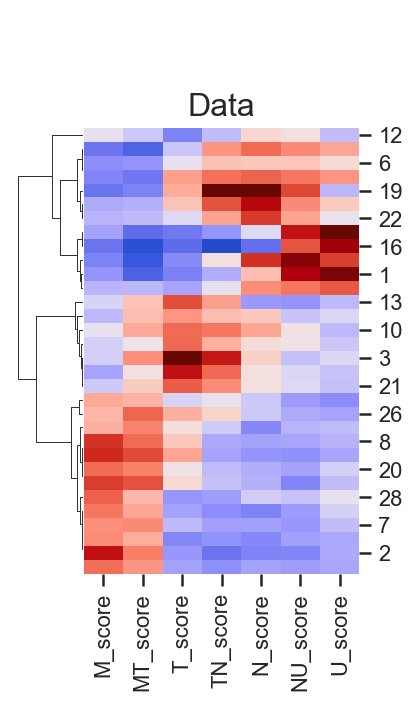

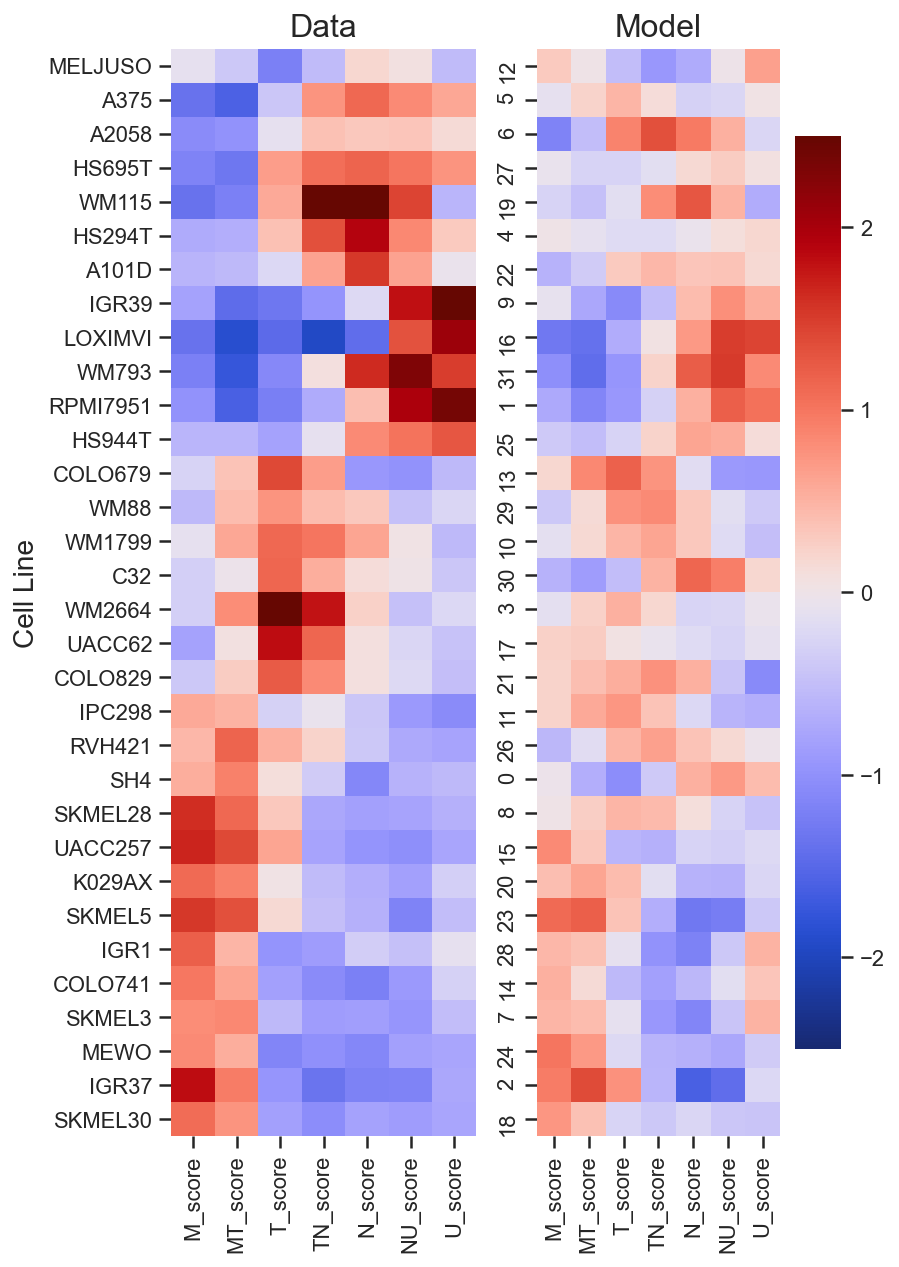

In [16]:
df_Y_pred_ccle = pd.DataFrame(Y_pred_ccle,columns = Y_ccle.columns)
df_Yz_ccle = pd.DataFrame(Yz_ccle,columns = Y_ccle.columns)


#cluster data
cmap = cc.CET_D1A
c = sns.clustermap(df_Yz_ccle,col_cluster=False,method ='average',metric = 'correlation',z_score=1,
                   cmap = cmap,center=0,vmax = 2.5,vmin = -2.5,figsize=(3,5),cbar_pos=None)

c.ax_heatmap.set_title('Data',fontsize = 16)

#order model prediction based on clustering of the data 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,10))
r_order = c.dendrogram_row.reordered_ind

df_Y_ordered_ccle = df_Yz_ccle.reindex(r_order)
df_Y_ordered_ccle.index = df_selected_ccle['cell_line'][r_order]
d = sns.heatmap(df_Y_ordered_ccle,cmap = cmap,center=0,vmax = 2.5,vmin = -2.5,ax = ax[0],cbar = False)
d.set_ylabel('Cell Line', fontsize = 14)
d.set_title('Data',fontsize = 16)

df_Y_pred_ordered_ccle = df_Y_pred_ccle.reindex(r_order)
m = sns.heatmap(df_Y_pred_ordered_ccle,cmap = cmap,center=0,vmax = 2.5,vmin = -2.5,ax = ax[1])
m.set_title('Model',fontsize = 16)

plt.savefig('CCLE_PLSR_Clustergram_Data_vs_Model.pdf', format='pdf')




#### - Save Prediction Output

In [17]:
df_Y_pred_ccle['cell_line'] = df_selected_ccle['cell_line']
df_Y_pred_ccle['True_Class'] = df_selected_ccle['True_Class']
df_Y_pred_ccle.to_csv('CCLE_PLSR_Prediction_Output.csv')